In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
# export
from decode_fish.imports import *

# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict
import torch.nn as nn
import torch.nn.functional as F
from decode_fish.funcs.predict import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

sys.path.append('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/FQ/istdeco/')

from istdeco import ISTDeco
# from utils import random_codebook, random_image_stack
# from codebook import Codebook
# from starfish.image import Filter

# sys.path.append('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/FQ/bardensr/')
# import bardensr

from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *

import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

In [7]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_8g4/num_iters:50000xbs:15xhigh:0.05/train.yaml')

In [9]:
from decode_fish.funcs.merfish_eval import *
bench_df, code_ref, targets = hydra.utils.instantiate(cfg.codebook, return_bench_df=True)
# bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True)
bench_df = get_mop_fov(bench_df, 151)
bench_df = nm_to_px(bench_df, [1.085,1.085,1.085])
bench_df['x'] += 70
bench_df['y'] += 70

17130008


In [ ]:
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
post_proc.codebook = torch.tensor(code_ref)

In [9]:
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *

def sim_data(decode_dl, batches, micro, model, channels=1, n_bits=1, sim_z=True, codebook=None):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        with torch.no_grad():
            x, local_rate, background = next(iter(decode_dl))
            sim_vars = PointProcessUniform(local_rate[:,0] ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=channels, n_bits=n_bits, sim_z=sim_z, codebook=codebook, int_option=cfg.training.int_option).sample(from_code_book=(codebook is not None))
            ch_inp = micro.get_single_ch_inputs(*sim_vars[:-1])
            xsim = micro(*ch_inp, add_noise=True, add_pos_noise=True)


            noise_vars = PointProcessUniform(local_rate[:,0] * cfg.genm.emitter_noise.rate_fac, int_conc=model.int_dist.int_conc.detach() * cfg.genm.emitter_noise.int_fac, 
                                           int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                           sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=1, 
                                           sim_z=cfg.genm.exp_type.pred_z, codebook=None, int_option=cfg.training.int_option).sample(from_code_book=False)     

            noise_inp = micro.get_single_ch_inputs(*noise_vars[:-1])
            xsim += micro(*noise_inp, add_noise=True)
        
            x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

            xsim_col.append(x)

            gt_vars = sim_vars[:-2] 
            gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
            gt_dfs.append(gt_df)
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        with torch.no_grad():
            pred_df = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=False)
            pred_dfs.append(pred_df)
        
    pred_df = cat_emitter_dfs(pred_dfs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=1000, print_res=print_res, match_genes=True, allow_multiple_matches=True)
    res_dict = None
    return perf, pred_df, matches, res_dict

In [10]:
xsim, gt = sim_data(decode_dl, 10, micro, model, channels=22, n_bits=4, sim_z=cfg.genm.exp_type.pred_z, codebook=torch.tensor(code_ref[:252]))

In [11]:
perf, pred_df, matches, res_dict = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

Recall: 0.517
Precision: 0.961
Jaccard: 50.613
RMSE_vol: 46.635
Eff_3d: 45.385
FN: 7878.0 FP: 345.0
Num. matches: 8427.000
Shift: -0.12,-0.07,2.24


In [18]:
# export
def get_istdeco_df(sim_data, codebook, psf_sig=(1.7, 1.7), n_iter=100, bg=100.):
    
    istd_results = pd.DataFrame()
    
    n_rounds = codebook.shape[1]
    n_cols = codebook.shape[2]
    
    for i in tqdm(range(len(sim_data))):

        image_data = np.array(sim_data)[i,:,0]
        image_data = image_data.reshape([n_rounds,n_cols,image_data.shape[-2],image_data.shape[-1]], order='F')
        
        init_th = np.percentile(image_data,50)

        istdeco_model = ISTDeco(image_data, codebook, psf_sig, b=bg)
        X, Q, loss = istdeco_model.run(niter=n_iter)

        # Get codes
        code_id, y, x = np.where(np.logical_and(X>init_th,Q>0.1))

        intensity = X[code_id, y, x]
        quality = Q[code_id, y, x]

        # Store in dataframe
        df = pd.DataFrame(data={
                'frame_idx': i,
                'x': x.astype('float')+0.5, 
                'y': y.astype('float')+0.5,
                'z': 0.5,
                'intensity': intensity, 
                'quality': quality,
                'code_inds': code_id
        })

        istd_results = istd_results.append(df)

    istd_results = px_to_nm(istd_results)

    return istd_results

In [18]:
istd_df = get_istdeco_df(cpu(xsim), code_ref.reshape([252,11,2], order='F'), psf_sig=(1.7, 1.7), n_iter=400)

100%|██████████████████████████████████████████████████████████| 150/150 [02:19<00:00,  1.07it/s]


(array([5.3795e+04, 7.9190e+03, 1.8030e+03, 6.2400e+02, 2.4100e+02,
        7.9000e+01, 4.2000e+01, 1.2000e+01, 6.0000e+00, 4.0000e+00]),
 array([0.10000049, 0.15906668, 0.21813287, 0.27719906, 0.33626524,
        0.39533144, 0.45439762, 0.5134638 , 0.57253003, 0.6315962 ,
        0.6906624 ], dtype=float32),
 <BarContainer object of 10 artists>)

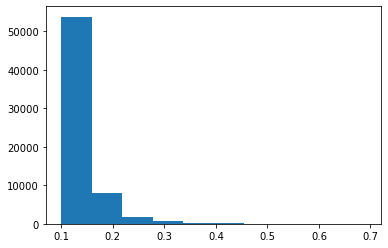

In [26]:
plt.hist(istd_df['quality'], biin)

In [35]:
sub_df = istd_df[istd_df['quality'] > 0.06]
sub_df = sub_df[sub_df['intensity'] > 2700]
print(len(sub_df))

13850


In [36]:
perf, matches, _  = matching(px_to_nm(gt, cfg.evaluation.px_size_zyx), sub_df, match_genes=True, tolerance=300)

Recall: 0.354
Precision: 0.416
Jaccard: 23.642
RMSE_vol: 72.863
Eff_3d: 15.396
FN: 10539.0 FP: 8084.0
Num. matches: 5766.000
Shift: 0.18,-0.55,-22.61


In [97]:
xsim.shape

torch.Size([150, 22, 1, 56, 56])

In [98]:
img_corr.shape

torch.Size([7, 22, 1, 2048, 2048])

In [37]:
# q_max = 0.3*istd_df['quality'].max()
# i_max = 0.3*istd_df['intensity'].max()
# i_min = istd_df['intensity'].min()

# def objective(trial):
    
#     n_iter = 400 # trial.suggest_uniform('n_iter', 50, 500)
#     psf_s = 1.7 # trial.suggest_uniform('psf_s', 1.5, 1.7)
    
# #     istd_df = get_istdeco_df(xsimn, code_ref.reshape([140,8,2], order='F'), psf_sig=(psf_s, psf_s), n_iter=int(n_iter))
# #     istd_df = exclude_borders(istd_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])
    
#     qual_th = trial.suggest_uniform('qual_th', 0.05, q_max)
#     int_th = trial.suggest_uniform('int_th', i_min, i_max)
    
#     sub_df = istd_df[(istd_df['intensity'] > int_th) & (istd_df['quality'] > qual_th)]
#     perf, matches, _  = matching(px_to_nm(gt, cfg.evaluation.px_size_zyx), sub_df, match_genes=True, print_res=False) 
    
#     return -perf['jaccard']

# study = optuna.create_study()
# study.optimize(objective, n_trials=200)

# print(study.best_params)
# print('Jaccard ', -study.best_value)

In [10]:
img = read_MOp_tiff('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images151.tif', z_to_batch=True, scaled=True)

In [11]:
max_p_151 = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images151.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]

In [12]:
fids_151 = get_peaks(max_p_151, 18000, 20)

In [417]:
from decode_fish.funcs.merfish_eval import *
bench_df, code_ref, targets = hydra.utils.instantiate(cfg.codebook, return_bench_df=True)
# bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True)
bench_df = get_mop_fov(bench_df, 151)
bench_df = nm_to_px(bench_df, [1.085,1.085,1.085])
bench_df['x'] += 70
bench_df['y'] += 70

17130008


In [94]:
len(bench_df)

58091

In [13]:
from decode_fish.funcs.dataset import GaussianSmoothing

In [14]:
smoother = GaussianSmoothing(smoothing_filter_size=3, z_size=1, device='cpu')
bg = smoother(img)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [15]:
img_corr = img - bg

NameError: name 'xsim' is not defined

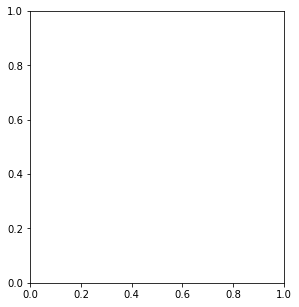

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(cpu(xsim)[0,7,0])
plt.colorbar()
plt.subplot(122)
plt.imshow(cpu(img_corr)[0,7,0,1000:1050,1000:1050])
plt.colorbar()

In [377]:
sub_img = img_corr[3:4,:,:,300:1800,300:1800]

In [282]:
bench_sub = crop_df(bench_df, np.s_[:,:,300:1800,300:1800], px_size_zyx=[1.0, 100., 100.])

In [297]:
istd_dfs = []
for var in [150,200,250]:
    istd_dfs.append(get_istdeco_df(sub_img + var, code_ref.reshape([252,11,2], order='F'), psf_sig=(1.3, 1.3), n_iter=100, bg=var))

100%|█████████████████████████████████████████████████████████████| 1/1 [05:29<00:00, 329.04s/it]


In [19]:
# Optimized over bg, sigma, and n_iter
istd_df_full = get_istdeco_df(img_corr + 200, code_ref.reshape([252,11,2], order='F'), psf_sig=(1.3, 1.3), n_iter=100, bg=200)

100%|███████████████████████████████████████████████████████████| 7/7 [1:33:34<00:00, 802.06s/it]


In [20]:
istd_df_full[istd_df_full['intensity'] > 500].nlargest(100000, 'quality').to_csv('../data/results/MERFISH/istdeco_MOp_151.csv', index=False)

In [410]:
istd_df_3 = get_istdeco_df(img_corr[3:4] + 200, code_ref.reshape([252,11,2], order='F'), psf_sig=(1.3, 1.3), n_iter=100, bg=200)

100%|█████████████████████████████████████████████████████████████| 1/1 [13:45<00:00, 825.21s/it]


In [381]:
istd_df_3_sub = get_istdeco_df(sub_img + 200, code_ref.reshape([252,11,2], order='F'), psf_sig=(1.3, 1.3), n_iter=100, bg=200)

100%|█████████████████████████████████████████████████████████████| 1/1 [05:32<00:00, 332.85s/it]


In [379]:
istd_df_3['gene'] = targets[istd_df_3['code_inds']]
istd_df_3['loc_idx'] = np.arange(len(istd_df_3))
istd_df_3 = exclude_borders(istd_df_3, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
istd_df_3 = remove_fids(istd_df_3, px_to_nm(fids_151), tolerance=1000)

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_clean['frame_idx'] = frames[inds]


In [411]:
tra = crop_df(istd_df_3, np.s_[:,:,300:1800,300:1800], px_size_zyx=[1.0, 100., 100.])

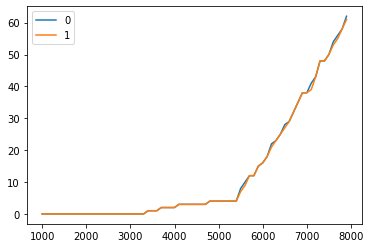

In [412]:
for i,df in enumerate([tra, istd_df_3_sub]):
    df['gene'] = targets[df['code_inds']]
    r  = make_roc(df, 'quality', n_max=8000, ascending=False)
    plt.plot(r[0],r[1], label=i)
plt.legend()

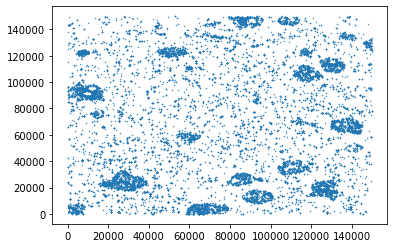

In [400]:
plt.scatter(tra['x'],tra['y'],s=0.2)

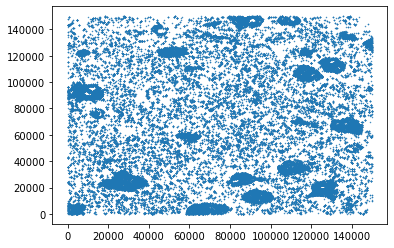

In [401]:
plt.scatter(istd_df_3_sub['x'],istd_df_3_sub['y'],s=0.2)

In [322]:
istd_df_full['gene'] = targets[istd_df_full['code_inds']]
istd_df_full['loc_idx'] = np.arange(len(istd_df_full))
istd_df_full = exclude_borders(istd_df_full, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
istd_df_full = remove_fids(istd_df_full, px_to_nm(fids_151), tolerance=1000)
bench_df = exclude_borders(bench_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
bench_df = remove_fids(bench_df, px_to_nm(fids_151), tolerance=1000)

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_clean['frame_idx'] = frames[inds]


36389 36500


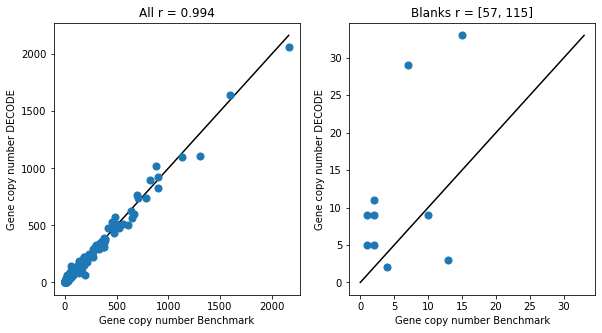

In [346]:
plot_gene_panels(istd_df_full[istd_df_full['intensity'] > 1000].nlargest(36500, 'quality'), bench_df, targets)

In [413]:
bla = crop_df(bench_df, np.s_[3:4,:,300:1800,300:1800], px_size_zyx=[1.0, 100., 100.])
# tra = crop_df(istd_df_full, np.s_[3:4,:,300:1800,300:1800], px_size_zyx=[1.0, 100., 100.])

4508 5000


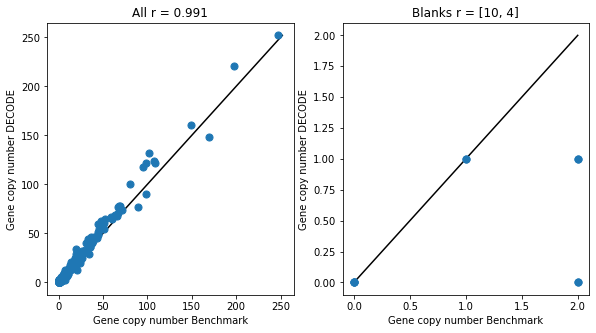

In [414]:
plot_gene_panels(tra[tra['intensity'] > 100].nlargest(5000, 'quality'), bla, targets)

In [358]:
_,_,_ = matching(bla,bench_sub[bench_sub['frame_idx']==3])

Recall: 0.000
Precision: 0.000
Jaccard: 0.000
RMSE_vol: 0.000
Eff_3d: 0.000
FN: 4508.0 FP: 4524.0
Num. matches: 0.000
Shift: nan,nan,nan


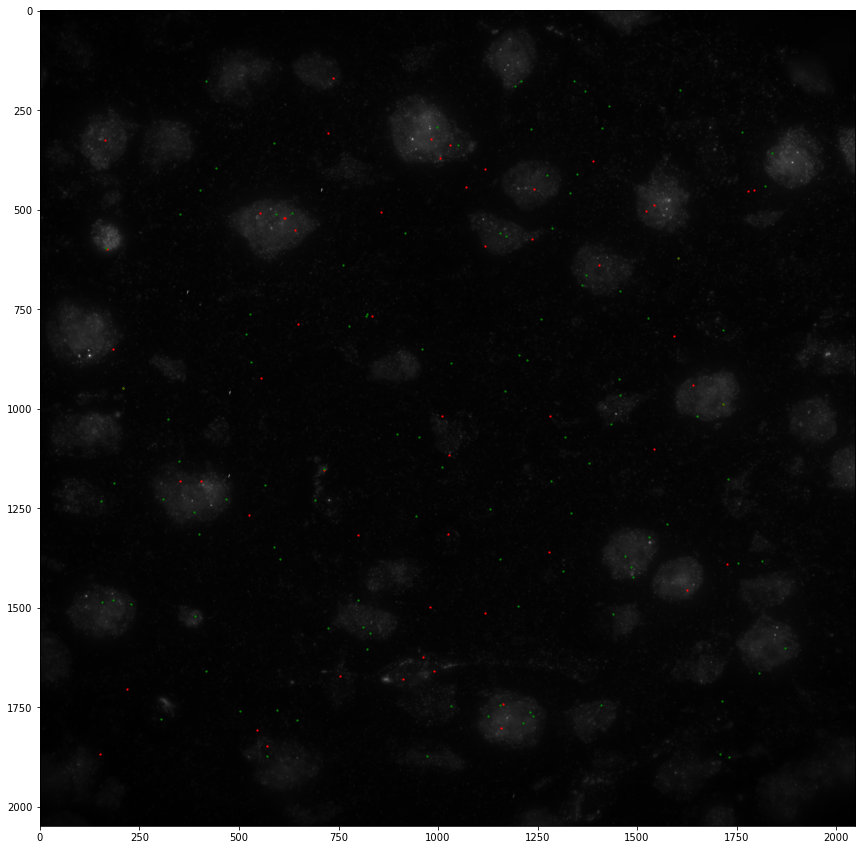

In [329]:
plt.figure(figsize=(15,15))
plt.imshow(max_p_151, cmap='gray')
bench_plt = nm_to_px(bench_df, [100.,100.,100.])[bench_df['gene'].str.contains('Blank')]
res_plt = istd_df_full[istd_df_full['intensity'] > 1000].nlargest(36500, 'quality')
res_plt = nm_to_px(res_plt[res_plt['gene'].str.contains('Blank')], [100.,100.,100.])
plt.scatter(bench_plt['x'], bench_plt['y'], s=1.5, color='red')
plt.scatter(res_plt['x'], res_plt['y'], s=1.5, color='green')


In [178]:
sub_df = istd_df[(istd_df['intensity'] > 2000) & (istd_df['quality'] > 0.2)]
sub_df['gene'] = targets[sub_df['code_inds']]

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [179]:
sub_df

,frame_idx,x,y,z,intensity,quality,code_inds,gene
4,0,149750.0,1550.0,50.0,2475.852539,0.677795,0,1700022I11Rik
107,0,183650.0,37250.0,50.0,2360.125000,0.441807,0,1700022I11Rik
328,0,15550.0,107750.0,50.0,2249.002686,0.511960,0,1700022I11Rik
451,0,77150.0,153450.0,50.0,2326.664062,0.559494,0,1700022I11Rik
501,0,116650.0,175550.0,50.0,2173.812500,0.629563,0,1700022I11Rik
...,...,...,...,...,...,...,...,...
213385,0,149350.0,62950.0,50.0,2021.304565,0.676546,251,Blank-10
213461,0,13250.0,84250.0,50.0,2835.812744,0.547172,251,Blank-10
213469,0,13750.0,85350.0,50.0,2749.275391,0.377879,251,Blank-10
213545,0,60850.0,105350.0,50.0,2357.331299,1.160465,251,Blank-10


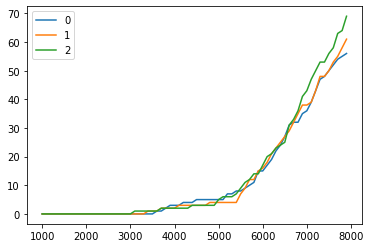

In [298]:
def make_roc(df, var='code_err', ascending=True, n_max=50000):
    
    if n_max is None:
        n_max = len(df)
    x = np.arange(1000,n_max,100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append((df[:int(i)]['gene'].str.contains('Blank')).sum())
        
    return x, n_blanks

for i,df in enumerate(istd_dfs):
    df['gene'] = targets[df['code_inds']]
    r  = make_roc(df, 'quality', n_max=8000, ascending=False)
    plt.plot(r[0],r[1], label=i)
plt.legend()

In [266]:
sub_df = istd_df[(istd_df['intensity'] > 500) & (istd_df['quality'] > 0.005)]
sub_df['gene'] = targets[sub_df['code_inds']]

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [418]:
istd_df_fc = istd_df_full.copy()
istd_df_fc['gene'] = targets[istd_df_fc['code_inds']]
istd_df_fc['loc_idx'] = np.arange(len(istd_df_fc))
istd_df_fc = exclude_borders(istd_df_fc, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])

In [419]:
bench_df = exclude_borders(bench_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])

36484 36500


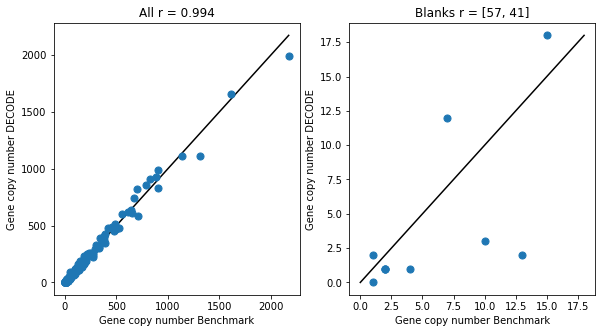

In [435]:
plot_gene_panels(istd_df_fc[istd_df_fc['intensity'] > 500].nlargest(36500, 'quality'), bench_df, targets)

In [432]:
len(istd_df_fc[istd_df_fc['intensity'] > 500])

294938